# Random Forest Regression

### Complexity: O(m.n.n.log(n))

n = samples

m = features

In [1]:
import pandas as pd

seed = 's1'

# Double Pole
base = '../../../../datalake/data_baseline/data/xdpole/initialconditions'
n_features = 6

ic = pd.read_csv(f"{base}/{seed}_run.csv")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

features = ic.columns[[i for i in range(n_features)]]
target = 'performance'
X, y = ic[features], ic[target]

start = 1000 * 10
X, y = X[start:], y[start:]
X = PolynomialFeatures(2).fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
import numpy as np
from utils import fit_cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

grid = {
    'n_estimators': [100, 200, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4, 8, 16, 32],
    'criterion' :['squared_error', 'poisson', 'friedman_mse']
}

reg = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=grid,
    n_iter=100,
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

params = fit_cv(reg, (X_train, y_train), 'random_forest')
print(params)

{'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 32, 'criterion': 'poisson'}


In [4]:
from critic import evolution

def model(X=[], y=[]):
    m = RandomForestRegressor(oob_score=True, **params)
    if len(X) + len(y) > 0:
        m.fit(X,y)
    return m

s, p, t = evolution(X, y, model, batch=100)
print(t)

66.14315516599999


<Axes: >

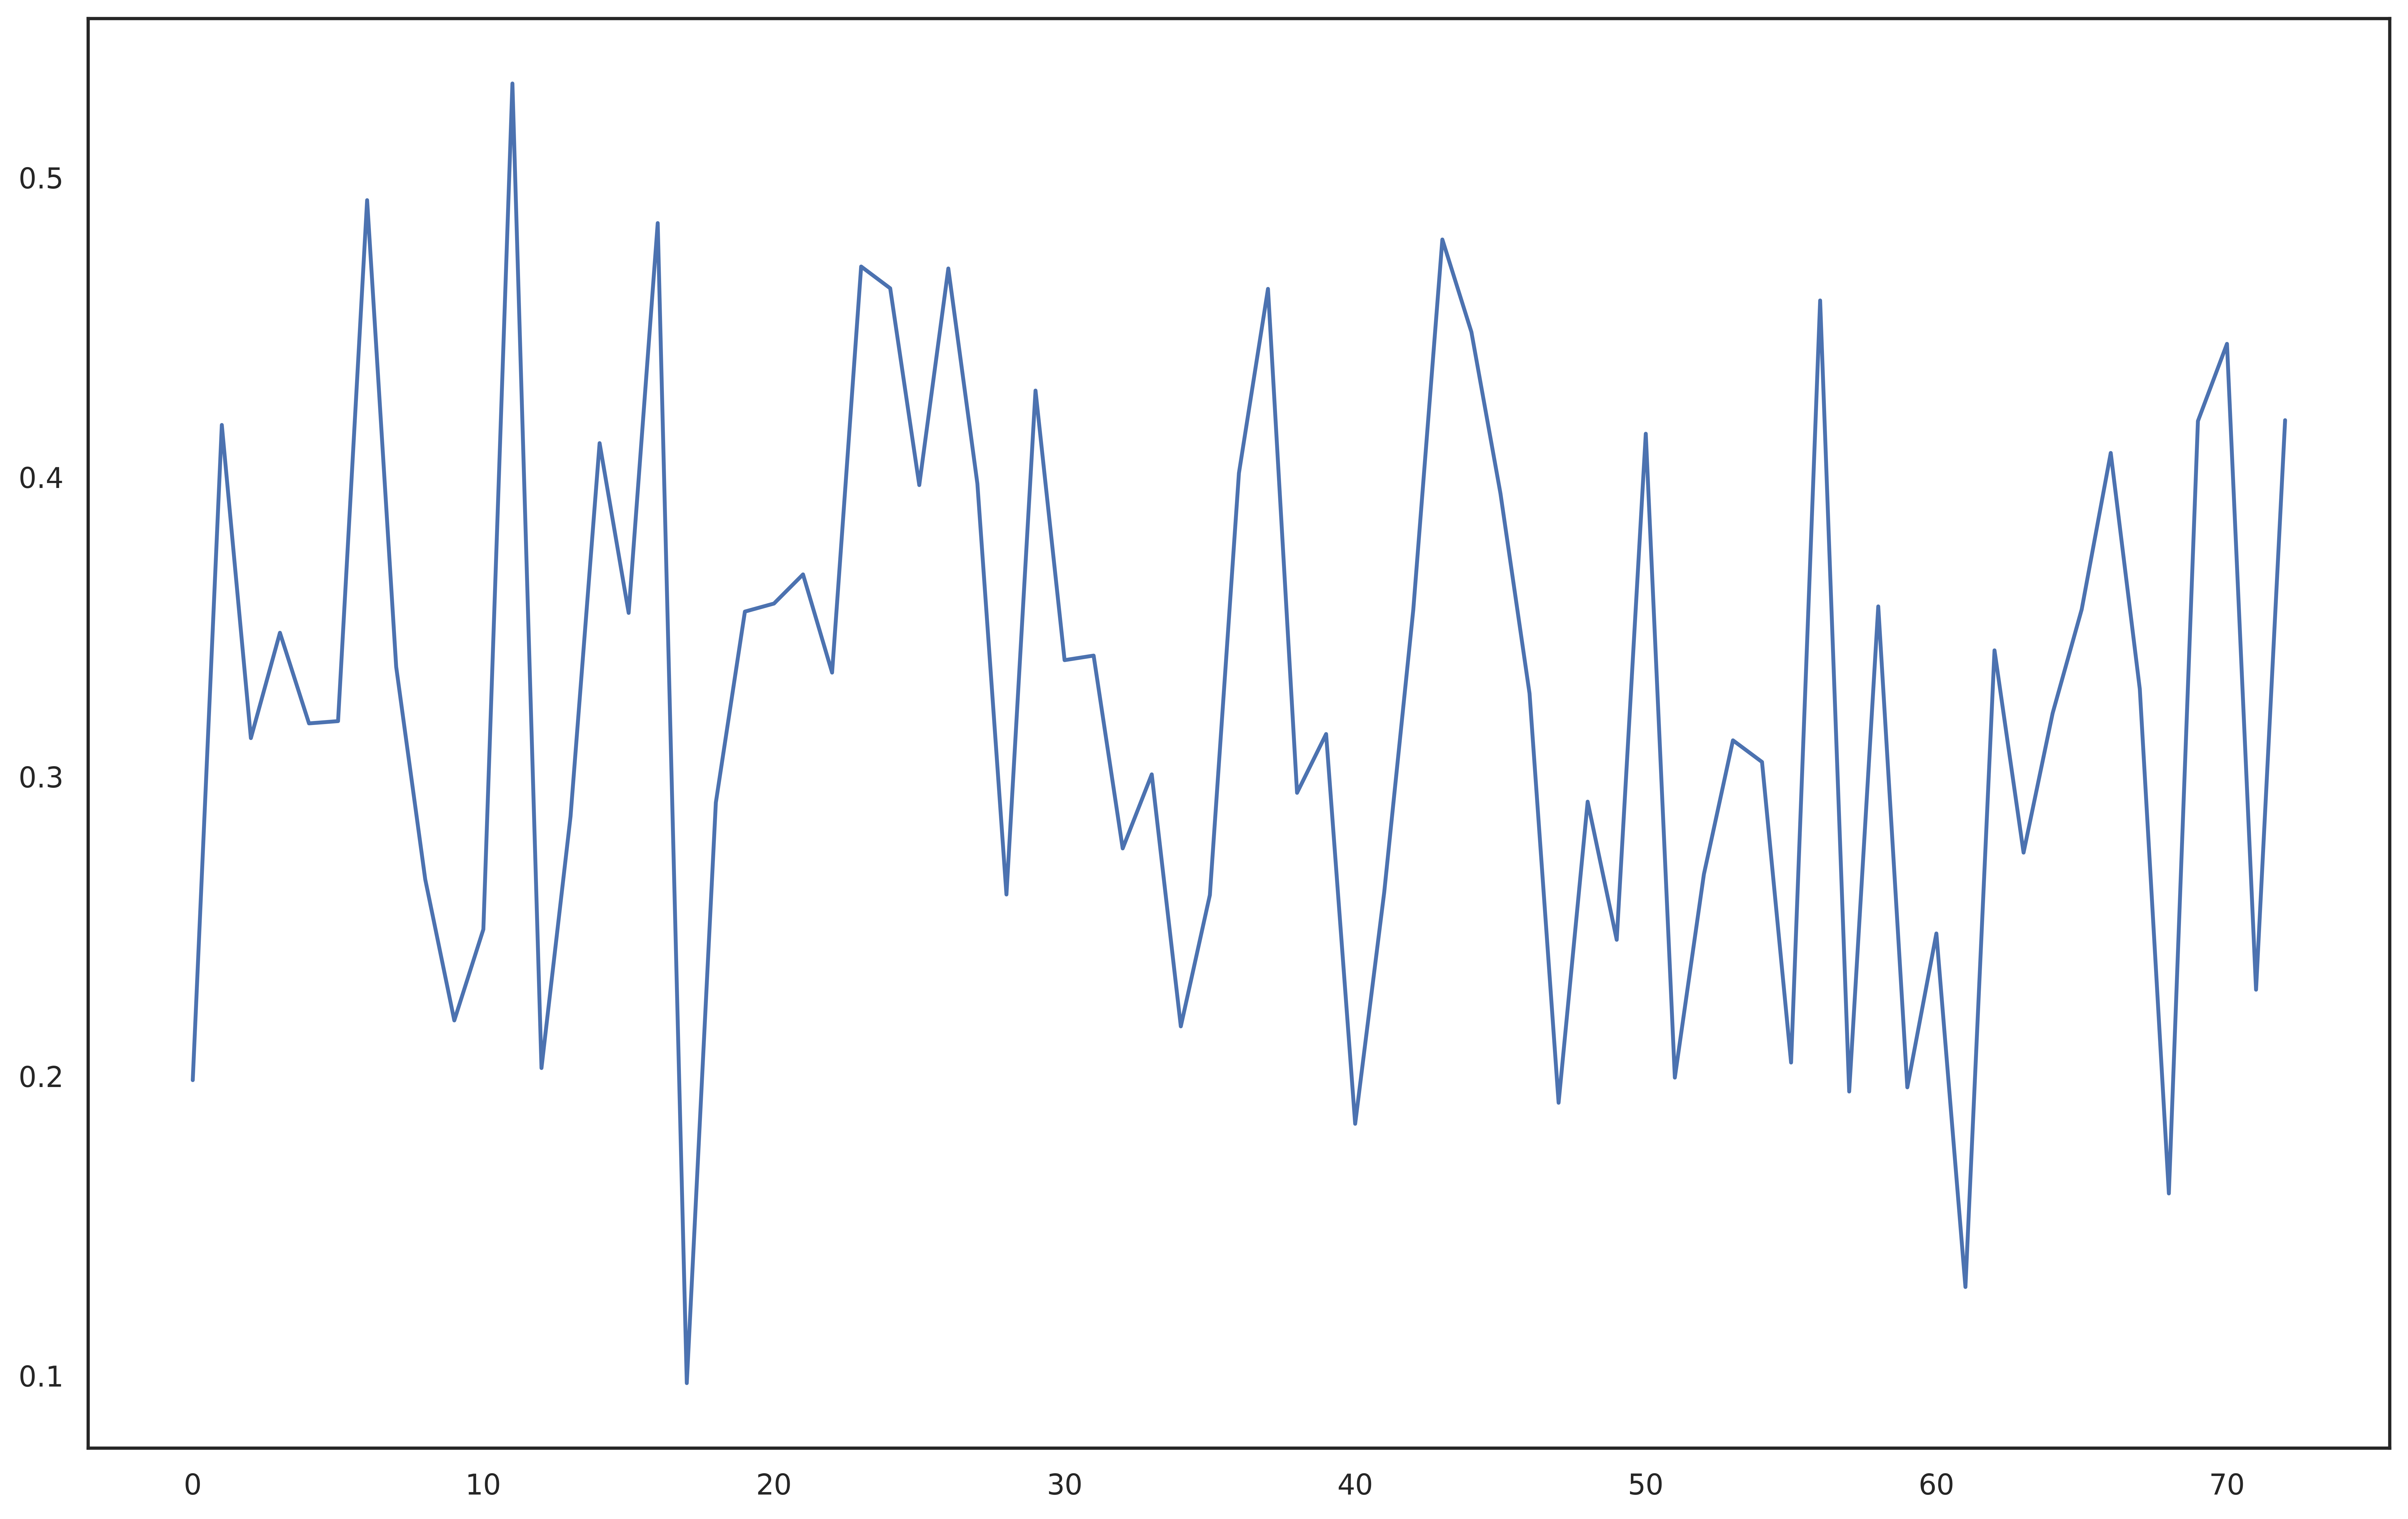

In [5]:
import seaborn as sns
from utils import graph_defaults
graph_defaults()

sns.lineplot(s)

<Axes: ylabel='Count'>

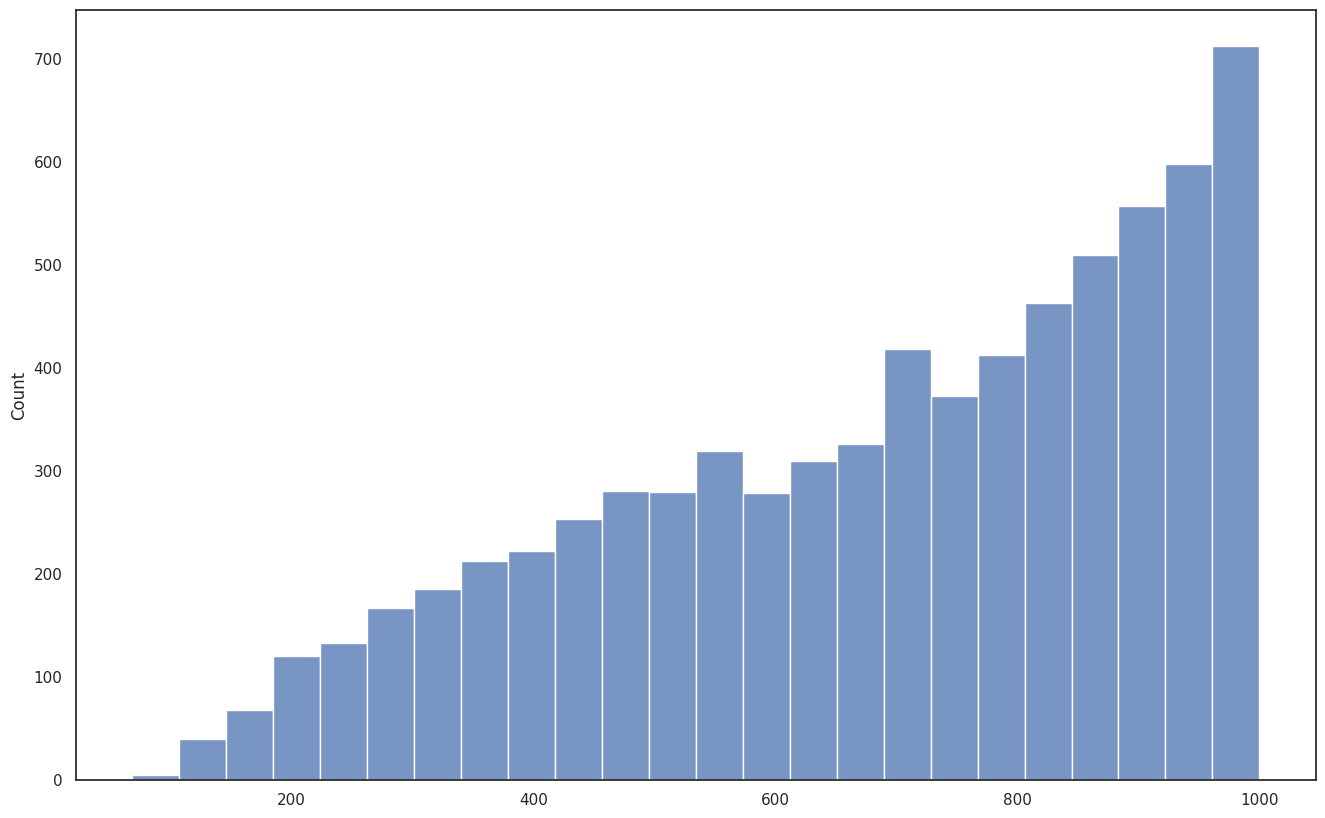

In [6]:
p = [yp for gen in p for yp in gen]

sns.histplot(p)

In [7]:
yt = [y[i] for i in range(start+1, len(y), 2)]

e = [p[i]/yt[i] for i in range(len(p))]
e_df = pd.DataFrame(e)
e_df.describe()

,0
count,7240.000000
mean,7.414285
std,11.284002
min,0.068245
25%,0.667723
50%,0.920872
75%,11.555255
max,65.254833


<Axes: ylabel='pos'>

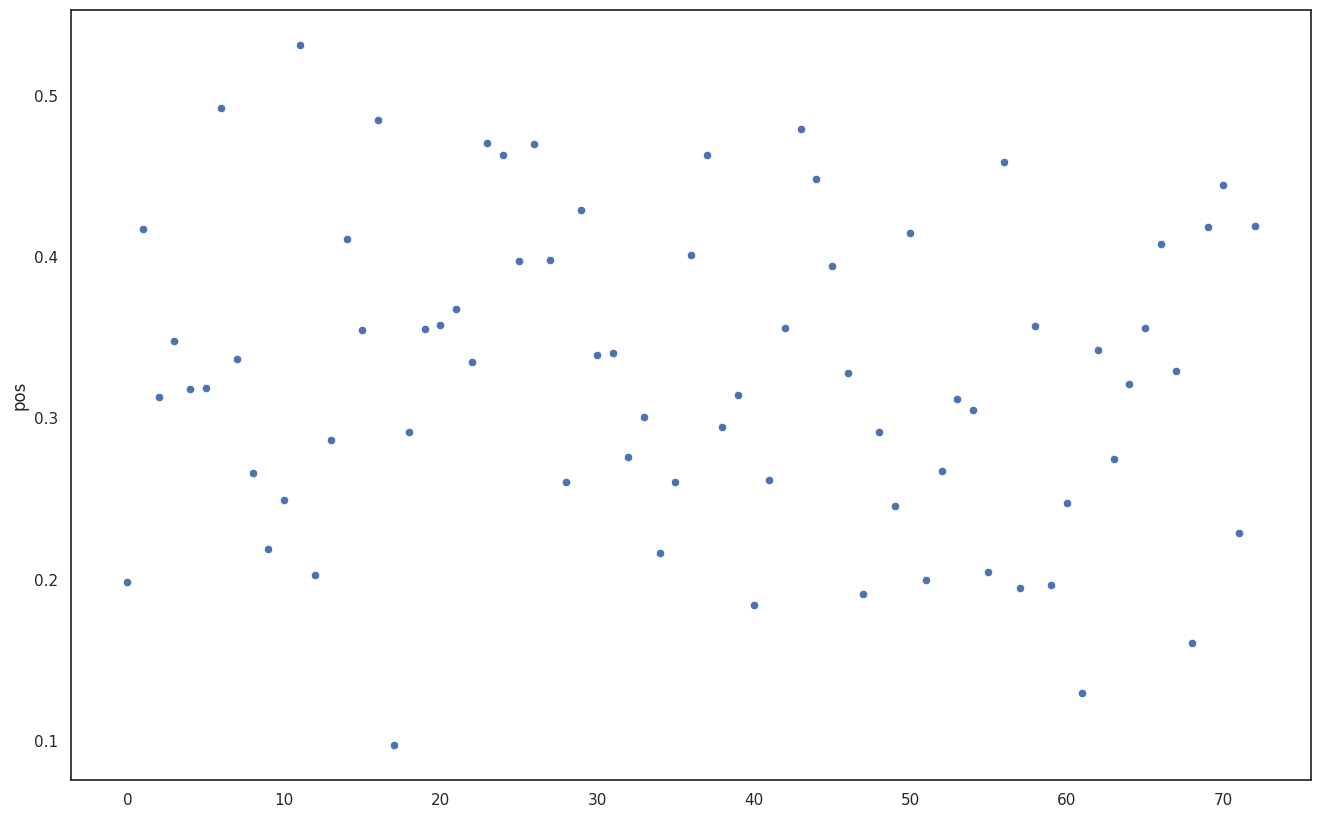

In [8]:
s_df = pd.DataFrame(s)
s_df.columns = ['raw']

s_df['pos'] = s_df.query('raw > 0').raw
s_df['neg'] = s_df.query('raw < 0').raw

sns.scatterplot(s_df['pos'])